In [1]:
# This code is to disable warnings that may display this notebook a little bit "ugly"
import warnings
warnings.filterwarnings('ignore')

In [1]:

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
# from bs4 import BeautifulSoup
%matplotlib inline


C:\Users\youne\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## get the data

In [2]:
data =pd.read_csv('data_ful_cleard.csv',encoding='utf-8',delimiter=';',error_bad_lines=False)

In [3]:
data['text'].apply(lambda x: len(x.split(' '))).sum()

1908133

## EDA

In [6]:
data.tail(2)

,text,label
115092,عجبتني خصيتان كي تجةنكةل بل أنجليس,tunisien
115093,طفل ظامر برشة ربي يوفقو,tunisien


In [7]:
data.head(2)

,text,label
0,اتمنى من الاداره الهلاليه تنبه لمشكلتين في اله...,gulf
1,الة اكبر ما خلو علينا اشي وبحكو ليش بنهاجر وبن...,levantine


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 2 columns):
text     116292 non-null object
label    116293 non-null object
dtypes: object(2)
memory usage: 1.8+ MB


In [8]:
data.groupby('label').describe()

text                                                            \
           count unique                                                top   
label                                                                        
egyptian   22105  22105  لأ تخافي يا إيمان إشتري من محل موثوق فيه شاهين...   
general    18903  18903                          خاصتاً انها محسومه مسبقاً   
gulf       24171  24171                      صح اله يدك ونفع اله بك وبرسمك   
iraqi        291    291          العراق فلسطين سجلهما علي وهيب ورزاق فرحان   
levantine  22987  22987                 الي عندنا ربا وسرقة وتحايل بس حلال   
maghrebi    9638   9638  مُتمسك بليس شعري ومافهمتش ندي تدخلات الرب انكو...   
tunisien   16999  16999                                        برافو يا جو   

                
          freq  
label           
egyptian     1  
general      1  
gulf         1  
iraqi        1  
levantine    1  
maghrebi     1  
tunisien     1

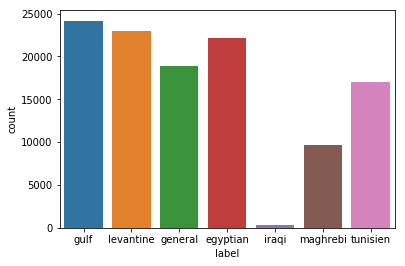

In [9]:
sns.countplot(x="label", data=data)

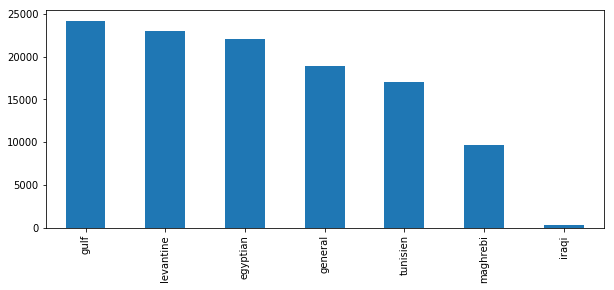

In [11]:
plt.figure(figsize=(10,4))
data.label.value_counts().plot(kind='bar');

## dialect classification 

In [4]:
X = data.text
y = data.label

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80565,) (34529,) (80565,) (34529,)


### using XGBClassifier model


In [6]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

gb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1)),
              ])
gb.fit(X_train, y_train)

C:\Users\youne\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [ ]:
from sklearn.metrics import classification_report
y_pred = gb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

# Model Evaluation
print(classification_report(y_pred, y_test))

### using naive bayes classification model


In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [18]:
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

# Model Evaluation
print(classification_report(y_pred, y_test))

accuracy 0.6864954096556518
             precision    recall  f1-score   support

   egyptian       0.86      0.70      0.77      8276
    general       0.27      0.90      0.42      1735
       gulf       0.83      0.61      0.70      9977
      iraqi       0.00      0.00      0.00         0
  levantine       0.77      0.57      0.66      9113
   maghrebi       0.23      0.99      0.37       657
   tunisien       0.88      0.93      0.91      4771

avg / total       0.79      0.69      0.71     34529



### Using Linear support vector machine

In [22]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

# Model Evaluation
print(classification_report(y_pred, y_test))


accuracy 0.6842364389353877
             precision    recall  f1-score   support

   egyptian       0.85      0.66      0.74      8721
    general       0.30      0.79      0.43      2154
       gulf       0.78      0.66      0.71      8691
      iraqi       0.00      0.00      0.00         3
  levantine       0.67      0.67      0.67      6789
   maghrebi       0.44      0.80      0.56      1576
   tunisien       0.93      0.71      0.81      6595

avg / total       0.76      0.68      0.71     34529



### Logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test))

accuracy 0.6734918474325929
             precision    recall  f1-score   support

   egyptian       0.75      0.77      0.76      6494
    general       0.48      0.46      0.47      5989
       gulf       0.65      0.67      0.66      7102
      iraqi       0.00      0.00      0.00         7
  levantine       0.62      0.59      0.61      7122
   maghrebi       0.65      0.85      0.74      2204
   tunisien       0.91      0.82      0.86      5611

avg / total       0.68      0.67      0.67     34529



### Doc2vec and Logistic Regression

In [35]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.label, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [32]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████████████████████████████████████████████████████████████████| 115094/115094 [00:00<00:00, 665670.00it/s]


In [33]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████████████████████████████████████████| 115094/115094 [00:00<00:00, 575775.30it/s]


In [36]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test))

accuracy 0.6952706420689855
             precision    recall  f1-score   support

   egyptian       0.81      0.78      0.79      6967
    general       0.42      0.50      0.46      4852
       gulf       0.76      0.66      0.70      8236
      iraqi       0.00      0.00      0.00        11
  levantine       0.67      0.66      0.67      6934
   maghrebi       0.53      0.77      0.63      1987
   tunisien       0.90      0.84      0.87      5542

avg / total       0.71      0.70      0.70     34529



### BOW with keras

In [37]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


In [40]:
train_size = int(len(data) * .7)

train_posts = data['text'][:train_size]
train_tags = data['label'][:train_size]

test_posts = data['text'][train_size:]
test_tags = data['label'][train_size:]

print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 80565
Test size: 34529


In [41]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [42]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [43]:
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [44]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [45]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (80565, 1000)
x_test shape: (34529, 1000)
y_train shape: (80565, 7)
y_test shape: (34529, 7)


In [46]:
batch_size = 32
epochs = 2

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 72508 samples, validate on 8057 samples
Epoch 1/2


16800/72508 [=====>........................] - ETA: 21:37 - loss: 1.9530 - acc: 0.09 - ETA: 5:56 - loss: 1.9226 - acc: 0.2266 - ETA: 2:52 - loss: 1.8895 - acc: 0.263 - ETA: 1:59 - loss: 1.8678 - acc: 0.256 - ETA: 1:34 - loss: 1.8351 - acc: 0.274 - ETA: 1:23 - loss: 1.8135 - acc: 0.277 - ETA: 1:12 - loss: 1.7869 - acc: 0.283 - ETA: 1:05 - loss: 1.7588 - acc: 0.287 - ETA: 1:00 - loss: 1.7395 - acc: 0.297 - ETA: 55s - loss: 1.7183 - acc: 0.317 - ETA: 52s - loss: 1.6972 - acc: 0.33 - ETA: 50s - loss: 1.6806 - acc: 0.33 - ETA: 47s - loss: 1.6626 - acc: 0.34 - ETA: 45s - loss: 1.6410 - acc: 0.35 - ETA: 44s - loss: 1.6235 - acc: 0.36 - ETA: 42s - loss: 1.6112 - acc: 0.36 - ETA: 41s - loss: 1.5964 - acc: 0.37 - ETA: 40s - loss: 1.5868 - acc: 0.37 - ETA: 39s - loss: 1.5720 - acc: 0.38 - ETA: 38s - loss: 1.5545 - acc: 0.39 - ETA: 38s - loss: 1.5424 - acc: 0.39 - ETA: 37s - loss: 1.5283 - acc: 0.40 - ETA: 36s - loss: 1.5186 - acc: 0.40 - ETA: 36s - loss: 1.5064 - acc: 0.41 - ETA: 35s - loss: 1.49

43008/72508 [================>.............] - ETA: 43s - loss: 1.1346 - acc: 0.54 - ETA: 43s - loss: 1.1345 - acc: 0.54 - ETA: 43s - loss: 1.1344 - acc: 0.54 - ETA: 43s - loss: 1.1341 - acc: 0.54 - ETA: 43s - loss: 1.1336 - acc: 0.54 - ETA: 43s - loss: 1.1332 - acc: 0.54 - ETA: 43s - loss: 1.1331 - acc: 0.54 - ETA: 43s - loss: 1.1329 - acc: 0.54 - ETA: 42s - loss: 1.1327 - acc: 0.54 - ETA: 42s - loss: 1.1325 - acc: 0.54 - ETA: 42s - loss: 1.1324 - acc: 0.54 - ETA: 42s - loss: 1.1323 - acc: 0.54 - ETA: 42s - loss: 1.1321 - acc: 0.54 - ETA: 42s - loss: 1.1320 - acc: 0.54 - ETA: 42s - loss: 1.1316 - acc: 0.54 - ETA: 42s - loss: 1.1316 - acc: 0.54 - ETA: 42s - loss: 1.1315 - acc: 0.54 - ETA: 42s - loss: 1.1312 - acc: 0.54 - ETA: 42s - loss: 1.1315 - acc: 0.54 - ETA: 42s - loss: 1.1309 - acc: 0.54 - ETA: 42s - loss: 1.1306 - acc: 0.54 - ETA: 42s - loss: 1.1302 - acc: 0.54 - ETA: 42s - loss: 1.1297 - acc: 0.54 - ETA: 42s - loss: 1.1294 - acc: 0.54 - ETA: 42s - loss: 1.1292 - acc: 0.54 - ETA

55136/72508 [=====================>........] - ETA: 31s - loss: 1.1084 - acc: 0.55 - ETA: 31s - loss: 1.1082 - acc: 0.55 - ETA: 31s - loss: 1.1081 - acc: 0.55 - ETA: 31s - loss: 1.1080 - acc: 0.55 - ETA: 31s - loss: 1.1079 - acc: 0.55 - ETA: 30s - loss: 1.1078 - acc: 0.55 - ETA: 30s - loss: 1.1077 - acc: 0.55 - ETA: 30s - loss: 1.1076 - acc: 0.55 - ETA: 30s - loss: 1.1075 - acc: 0.55 - ETA: 30s - loss: 1.1075 - acc: 0.55 - ETA: 30s - loss: 1.1075 - acc: 0.55 - ETA: 30s - loss: 1.1074 - acc: 0.55 - ETA: 30s - loss: 1.1072 - acc: 0.55 - ETA: 30s - loss: 1.1073 - acc: 0.55 - ETA: 30s - loss: 1.1072 - acc: 0.55 - ETA: 30s - loss: 1.1071 - acc: 0.55 - ETA: 30s - loss: 1.1071 - acc: 0.55 - ETA: 30s - loss: 1.1070 - acc: 0.55 - ETA: 30s - loss: 1.1068 - acc: 0.55 - ETA: 30s - loss: 1.1069 - acc: 0.55 - ETA: 30s - loss: 1.1068 - acc: 0.55 - ETA: 30s - loss: 1.1067 - acc: 0.55 - ETA: 30s - loss: 1.1065 - acc: 0.55 - ETA: 30s - loss: 1.1064 - acc: 0.55 - ETA: 30s - loss: 1.1064 - acc: 0.55 - ETA

66656/72508 [==========================>...] - ETA: 19s - loss: 1.0907 - acc: 0.55 - ETA: 18s - loss: 1.0909 - acc: 0.55 - ETA: 18s - loss: 1.0910 - acc: 0.55 - ETA: 18s - loss: 1.0909 - acc: 0.55 - ETA: 18s - loss: 1.0906 - acc: 0.55 - ETA: 18s - loss: 1.0905 - acc: 0.55 - ETA: 18s - loss: 1.0901 - acc: 0.55 - ETA: 18s - loss: 1.0900 - acc: 0.55 - ETA: 18s - loss: 1.0898 - acc: 0.55 - ETA: 18s - loss: 1.0896 - acc: 0.55 - ETA: 18s - loss: 1.0895 - acc: 0.55 - ETA: 18s - loss: 1.0896 - acc: 0.55 - ETA: 18s - loss: 1.0896 - acc: 0.55 - ETA: 18s - loss: 1.0896 - acc: 0.55 - ETA: 18s - loss: 1.0896 - acc: 0.55 - ETA: 18s - loss: 1.0895 - acc: 0.55 - ETA: 18s - loss: 1.0895 - acc: 0.55 - ETA: 18s - loss: 1.0894 - acc: 0.55 - ETA: 18s - loss: 1.0893 - acc: 0.55 - ETA: 18s - loss: 1.0891 - acc: 0.55 - ETA: 18s - loss: 1.0891 - acc: 0.55 - ETA: 18s - loss: 1.0889 - acc: 0.55 - ETA: 18s - loss: 1.0889 - acc: 0.55 - ETA: 17s - loss: 1.0889 - acc: 0.55 - ETA: 17s - loss: 1.0890 - acc: 0.55 - ETA

72508/72508 [==============================] - ETA: 6s - loss: 1.0781 - acc: 0.559 - ETA: 6s - loss: 1.0781 - acc: 0.559 - ETA: 6s - loss: 1.0781 - acc: 0.559 - ETA: 6s - loss: 1.0781 - acc: 0.559 - ETA: 6s - loss: 1.0778 - acc: 0.559 - ETA: 6s - loss: 1.0778 - acc: 0.559 - ETA: 6s - loss: 1.0777 - acc: 0.559 - ETA: 6s - loss: 1.0777 - acc: 0.560 - ETA: 5s - loss: 1.0780 - acc: 0.559 - ETA: 5s - loss: 1.0780 - acc: 0.559 - ETA: 5s - loss: 1.0781 - acc: 0.559 - ETA: 5s - loss: 1.0781 - acc: 0.559 - ETA: 5s - loss: 1.0781 - acc: 0.559 - ETA: 5s - loss: 1.0781 - acc: 0.559 - ETA: 5s - loss: 1.0781 - acc: 0.559 - ETA: 5s - loss: 1.0782 - acc: 0.559 - ETA: 5s - loss: 1.0782 - acc: 0.559 - ETA: 5s - loss: 1.0782 - acc: 0.559 - ETA: 5s - loss: 1.0783 - acc: 0.559 - ETA: 5s - loss: 1.0784 - acc: 0.559 - ETA: 5s - loss: 1.0782 - acc: 0.559 - ETA: 5s - loss: 1.0780 - acc: 0.559 - ETA: 4s - loss: 1.0780 - acc: 0.559 - ETA: 4s - loss: 1.0779 - acc: 0.559 - ETA: 4s - loss: 1.0779 - acc: 0.559 - ETA

12832/72508 [====>.........................] - ETA: 1:28 - loss: 1.1346 - acc: 0.375 - ETA: 1:21 - loss: 0.9265 - acc: 0.572 - ETA: 1:18 - loss: 0.9247 - acc: 0.568 - ETA: 1:19 - loss: 0.9258 - acc: 0.602 - ETA: 1:17 - loss: 0.9814 - acc: 0.583 - ETA: 1:18 - loss: 0.9614 - acc: 0.585 - ETA: 1:18 - loss: 0.9554 - acc: 0.598 - ETA: 1:17 - loss: 0.9369 - acc: 0.604 - ETA: 1:17 - loss: 0.9449 - acc: 0.599 - ETA: 1:17 - loss: 0.9660 - acc: 0.590 - ETA: 1:17 - loss: 0.9911 - acc: 0.590 - ETA: 1:17 - loss: 1.0020 - acc: 0.581 - ETA: 1:17 - loss: 0.9987 - acc: 0.581 - ETA: 1:17 - loss: 0.9978 - acc: 0.581 - ETA: 1:17 - loss: 0.9898 - acc: 0.585 - ETA: 1:16 - loss: 0.9780 - acc: 0.588 - ETA: 1:16 - loss: 0.9771 - acc: 0.590 - ETA: 1:16 - loss: 0.9708 - acc: 0.591 - ETA: 1:16 - loss: 0.9718 - acc: 0.590 - ETA: 1:16 - loss: 0.9710 - acc: 0.591 - ETA: 1:16 - loss: 0.9677 - acc: 0.595 - ETA: 1:16 - loss: 0.9655 - acc: 0.598 - ETA: 1:16 - loss: 0.9670 - acc: 0.596 - ETA: 1:16 - loss: 0.9642 - acc: 0

35776/72508 [=============>................] - ETA: 58s - loss: 0.9681 - acc: 0.60 - ETA: 58s - loss: 0.9681 - acc: 0.60 - ETA: 57s - loss: 0.9679 - acc: 0.60 - ETA: 57s - loss: 0.9676 - acc: 0.60 - ETA: 57s - loss: 0.9678 - acc: 0.60 - ETA: 57s - loss: 0.9680 - acc: 0.60 - ETA: 57s - loss: 0.9680 - acc: 0.60 - ETA: 57s - loss: 0.9681 - acc: 0.60 - ETA: 57s - loss: 0.9678 - acc: 0.60 - ETA: 57s - loss: 0.9682 - acc: 0.60 - ETA: 57s - loss: 0.9680 - acc: 0.60 - ETA: 57s - loss: 0.9682 - acc: 0.60 - ETA: 57s - loss: 0.9684 - acc: 0.60 - ETA: 57s - loss: 0.9687 - acc: 0.60 - ETA: 57s - loss: 0.9686 - acc: 0.60 - ETA: 57s - loss: 0.9687 - acc: 0.60 - ETA: 57s - loss: 0.9685 - acc: 0.60 - ETA: 57s - loss: 0.9682 - acc: 0.60 - ETA: 57s - loss: 0.9679 - acc: 0.60 - ETA: 57s - loss: 0.9682 - acc: 0.60 - ETA: 57s - loss: 0.9683 - acc: 0.60 - ETA: 57s - loss: 0.9683 - acc: 0.60 - ETA: 57s - loss: 0.9684 - acc: 0.60 - ETA: 57s - loss: 0.9686 - acc: 0.60 - ETA: 57s - loss: 0.9689 - acc: 0.60 - ETA

47040/72508 [==================>...........] - ETA: 45s - loss: 0.9794 - acc: 0.59 - ETA: 44s - loss: 0.9798 - acc: 0.59 - ETA: 44s - loss: 0.9796 - acc: 0.59 - ETA: 44s - loss: 0.9795 - acc: 0.59 - ETA: 44s - loss: 0.9796 - acc: 0.59 - ETA: 44s - loss: 0.9794 - acc: 0.59 - ETA: 44s - loss: 0.9794 - acc: 0.59 - ETA: 44s - loss: 0.9794 - acc: 0.59 - ETA: 44s - loss: 0.9795 - acc: 0.59 - ETA: 44s - loss: 0.9802 - acc: 0.59 - ETA: 44s - loss: 0.9804 - acc: 0.59 - ETA: 44s - loss: 0.9805 - acc: 0.59 - ETA: 44s - loss: 0.9807 - acc: 0.59 - ETA: 44s - loss: 0.9805 - acc: 0.59 - ETA: 44s - loss: 0.9805 - acc: 0.59 - ETA: 44s - loss: 0.9805 - acc: 0.59 - ETA: 44s - loss: 0.9804 - acc: 0.59 - ETA: 44s - loss: 0.9807 - acc: 0.59 - ETA: 43s - loss: 0.9809 - acc: 0.59 - ETA: 43s - loss: 0.9808 - acc: 0.59 - ETA: 43s - loss: 0.9808 - acc: 0.59 - ETA: 43s - loss: 0.9805 - acc: 0.59 - ETA: 43s - loss: 0.9806 - acc: 0.59 - ETA: 43s - loss: 0.9807 - acc: 0.59 - ETA: 43s - loss: 0.9803 - acc: 0.59 - ETA

61760/72508 [========================>.....] - ETA: 31s - loss: 0.9779 - acc: 0.59 - ETA: 31s - loss: 0.9778 - acc: 0.59 - ETA: 31s - loss: 0.9779 - acc: 0.59 - ETA: 31s - loss: 0.9778 - acc: 0.59 - ETA: 31s - loss: 0.9779 - acc: 0.59 - ETA: 31s - loss: 0.9778 - acc: 0.59 - ETA: 31s - loss: 0.9778 - acc: 0.59 - ETA: 30s - loss: 0.9778 - acc: 0.59 - ETA: 30s - loss: 0.9780 - acc: 0.59 - ETA: 30s - loss: 0.9780 - acc: 0.59 - ETA: 30s - loss: 0.9781 - acc: 0.59 - ETA: 30s - loss: 0.9782 - acc: 0.59 - ETA: 30s - loss: 0.9782 - acc: 0.59 - ETA: 30s - loss: 0.9784 - acc: 0.59 - ETA: 30s - loss: 0.9783 - acc: 0.59 - ETA: 30s - loss: 0.9784 - acc: 0.59 - ETA: 30s - loss: 0.9785 - acc: 0.59 - ETA: 30s - loss: 0.9786 - acc: 0.59 - ETA: 30s - loss: 0.9785 - acc: 0.59 - ETA: 29s - loss: 0.9787 - acc: 0.59 - ETA: 29s - loss: 0.9786 - acc: 0.59 - ETA: 29s - loss: 0.9784 - acc: 0.59 - ETA: 29s - loss: 0.9784 - acc: 0.59 - ETA: 29s - loss: 0.9785 - acc: 0.59 - ETA: 29s - loss: 0.9784 - acc: 0.59 - ETA

72508/72508 [==============================] - ETA: 12s - loss: 0.9823 - acc: 0.59 - ETA: 12s - loss: 0.9821 - acc: 0.59 - ETA: 12s - loss: 0.9822 - acc: 0.59 - ETA: 11s - loss: 0.9825 - acc: 0.59 - ETA: 11s - loss: 0.9827 - acc: 0.59 - ETA: 11s - loss: 0.9826 - acc: 0.59 - ETA: 11s - loss: 0.9826 - acc: 0.59 - ETA: 11s - loss: 0.9826 - acc: 0.59 - ETA: 11s - loss: 0.9826 - acc: 0.59 - ETA: 11s - loss: 0.9826 - acc: 0.59 - ETA: 11s - loss: 0.9826 - acc: 0.59 - ETA: 11s - loss: 0.9827 - acc: 0.59 - ETA: 11s - loss: 0.9825 - acc: 0.59 - ETA: 11s - loss: 0.9825 - acc: 0.59 - ETA: 11s - loss: 0.9824 - acc: 0.59 - ETA: 11s - loss: 0.9825 - acc: 0.59 - ETA: 10s - loss: 0.9825 - acc: 0.59 - ETA: 10s - loss: 0.9824 - acc: 0.59 - ETA: 10s - loss: 0.9824 - acc: 0.59 - ETA: 10s - loss: 0.9826 - acc: 0.59 - ETA: 10s - loss: 0.9827 - acc: 0.59 - ETA: 10s - loss: 0.9828 - acc: 0.59 - ETA: 10s - loss: 0.9826 - acc: 0.59 - ETA: 10s - loss: 0.9826 - acc: 0.59 - ETA: 10s - loss: 0.9825 - acc: 0.59 - ETA

In [52]:
score = model.evaluate(x_test, y_test,batch_size=batch_size, verbose=1)

34529/34529 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - E

In [53]:
print('Test accuracy:', score[1])

Test accuracy: 0.1525384459439891


In [16]:
with open('pipelineNB1.pickle', 'rb') as handle:
    NB = pickle.load(handle)
NB.predict(["شكون حالك"])[0]

'tunisien'

In [17]:
NB.predict(["هوا في ايه"])[0]


'egyptian'

In [18]:
NB.predict(["انا عاوز أوجه تحيه للدوله العميقه اللى كل يوم بتثبت ان البلد دى فيها رجاله عارفه بتعمل ايه فعلا و امتى و ازاى ، فى اسبوعي…"])[0]

'egyptian'

In [19]:
NB.predict(["انا خوش مشتاقلك"])[0]

'gulf'

In [20]:
NB.predict(["إلا لا و على دارهم و شنوة تقصد بيها الكلمة باش تقراو "])[0]

'maghrebi'

In [21]:
NB.predict(["انا خوش مشتاقلك"])[0]

'gulf'

In [22]:
NB.predict(["يولد جميع الناس أحرارا ومتساوين في الكرامة والحقوق. وهم قد وهبوا العقل والوجدان وعليهم أن"])[0]

'general'

### cross validation

In [23]:
%time scoresNB = cross_val_score(pipelineNB, X_train, y_train, cv = 5)
print("Cross-validation scores: {}".format(scoresNB))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scoresNB.mean(), scoresNB.std()))
scoresNB = scoresNB.mean()

Wall time: 46.3 s
Cross-validation scores: [0.67678084 0.68544834 0.6854093  0.68102539 0.67641217]
Average cross-validation score: 0.68 +/- 0.00


#### learining curve

In [24]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    This function is to generate a simple plot of the test and traning learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Wall time: 1min 35s


<module 'matplotlib.pyplot' from 'C:\\Users\\youne\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

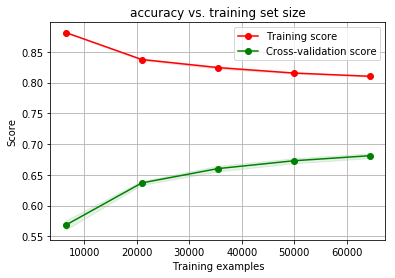

In [25]:
%time plot_learning_curve(pipelineNB, "accuracy vs. training set size", X_train, y_train, cv=5)

In [26]:
data.to_csv("data_ful_cleard.csv", sep=';', encoding='utf-8',index=False)